In [1]:
# Parameters. Set defaults here.
# Times Square replaces this cell with the user's parameters.
record_limit = '999'

<a class="anchor" id="imports"></a>
## Imports and General Setup

In [2]:
# Only use packages available in the Rubin Science Platform
import requests
from collections import defaultdict
import pandas as pd
from pprint import pp
from urllib.parse import urlencode
from IPython.display import FileLink, display_markdown
from matplotlib import pyplot as plt
import os

In [3]:
limit = int(record_limit)

response_timeout = 3.05  # seconds, how long to wait for connection
read_timeout = 20  # seconds
timeout = (float(response_timeout), float(read_timeout))

server = os.environ.get('EXTERNAL_INSTANCE_URL', 
                         'https://tucson-teststand.lsst.codes')
log = 'exposurelog'
service = f'{server}/{log}'
service

'https://tucson-teststand.lsst.codes/exposurelog'

<a class="anchor" id="setup_source"></a>
## Setup Source

In [4]:
recs = None
ok = True

# is_human=either&is_valid=either&offset=0&limit=50' 
# site_ids=tucson&message_text=wubba&min_level=0&max_level=999&user_ids=spothier&user_agents=LOVE
# tags=love&exclude_tags=ignore_message
qparams = dict(is_human='either',
               is_valid='either',
               limit=limit,
              )
qstr = urlencode(qparams)
url = f'{service}/messages?{qstr}'

ignore_fields = set(['tags', 'urls', 'message_text', 'id', 'date_added', 
                     'obs_id', 'day_obs', 'seq_num', 'parent_id', 'user_id',
                     'date_invalidated', 'date_begin', 'date_end',
                     'time_lost', # float
                     #'systems','subsystems','cscs',  # values are lists, special handling
                    ])

<a class="anchor" id="get_records"></a>
## Get Records

In [5]:
try:
    print(f'Attempt to get logs from {url=}')
    response = requests.get(url, timeout=timeout)
    response.raise_for_status()
    recs = response.json()
    flds = set(recs[0].keys())
    facflds = flds - ignore_fields
    # facets(field) = set(value-1, value-2, ...)
    facets = {fld: set([str(r[fld])
                for r in recs if not isinstance(r[fld], list)]) 
                    for fld in facflds}
except Exception as err:
    ok = False
    print(f'ERROR getting {log} from {env=} using {url=}: {err=}')
numf = len(flds) if ok else 0
numr = len(recs) if ok else 0
print(f'Retrieved {numr} records, each with {numf=} fields.')

Attempt to get logs from url='https://tucson-teststand.lsst.codes/exposurelog/messages?is_human=either&is_valid=either&limit=999'
Retrieved 21 records, each with numf=18 fields.


<a class="anchor" id="table"></a>
## Tables of (mostly raw) results

### Fields names provided in records from log.

In [6]:
pd.DataFrame(flds, columns=['Field Name'])

,Field Name
0,seq_num
1,urls
2,site_id
3,exposure_flag
4,date_invalidated
5,user_id
6,is_human
7,message_text
8,day_obs
9,instrument


### Facets from log records.
A *facet* is the set all of values found for a field in the retrieved records. Facets are only calculated for some fields.

In [7]:
pd.DataFrame.from_dict(facets, orient='index')

,0,1,2
exposure_flag,none,questionable,junk
site_id,tucson,None,None
is_human,True,None,None
instrument,LATISS,LSSTComCam,None
level,10,None,None
user_agent,LOVE,None,None
is_valid,False,True,None


### Table of selected log record fields.
Table can be retrieved as CSV file for local use.

In [8]:
cols = ['obs_id', 'user_id', 'user_agent','is_human','is_valid','exposure_flag']
df = pd.DataFrame(recs)[cols]

# Allow download of CSV version of DataFrame
csvfile = 'tl.csv'
df.to_csv(csvfile)
myfile = FileLink(csvfile)
print('Table available as CSV file: ')
display(myfile)
df

Table available as CSV file: 


/home/pothiers/sandbox/ts_logging_and_reporting/notebooks_tsqr/tl.csv

,obs_id,user_id,user_agent,is_human,is_valid,exposure_flag
0,AT_O_20221129_000001,admin@love1.tu.lsst.org,LOVE,True,True,junk
1,AT_C_20230613_000001,admin@love1.tu.lsst.org,LOVE,True,False,none
2,AT_O_20230906_000003,tribeiro@tucson-teststand.lsst.codes,LOVE,True,True,questionable
3,AT_C_20230613_000001,admin@love1.tu.lsst.org,LOVE,True,False,none
4,AT_O_20230906_000003,admin@localhost,LOVE,True,True,none
5,AT_O_20221129_000001,admin@love1.tu.lsst.org,LOVE,True,True,questionable
6,AT_O_20221115_000020,admin@love1.tu.lsst.org,LOVE,True,True,questionable
7,AT_O_20221115_000023,admin@love1.tu.lsst.org,LOVE,True,True,none
8,AT_O_20230830_000003,admin@localhost,LOVE,True,False,none
9,AT_O_20230830_000003,admin@localhost,LOVE,True,False,none


In [9]:
df = pd.DataFrame(recs)
df

,id,site_id,obs_id,instrument,day_obs,seq_num,message_text,level,tags,urls,user_id,user_agent,is_human,is_valid,exposure_flag,date_added,date_invalidated,parent_id
0,0076ce05-752f-46df-b8a5-90ffd51d612e,tucson,AT_O_20221129_000001,LSSTComCam,20221129,1,this was a test image for LOVE LVV November te...,10,[undefined],[],admin@love1.tu.lsst.org,LOVE,True,True,junk,2022-11-30T02:13:46.847038,None,None
1,1e61fbbe-cb87-45f2-88be-cb6647b0cd43,tucson,AT_C_20230613_000001,LATISS,20230613,1,Exposure log creation test,10,[undefined],[],admin@love1.tu.lsst.org,LOVE,True,False,none,2023-07-18T22:13:41.228510,2023-07-18T22:15:14.006037,None
2,21fc4a19-37af-42c1-b475-c6cd26df21b5,tucson,AT_O_20230906_000003,LATISS,20230906,3,Testing exposure log in OLE!\r\n,10,[undefined],[],tribeiro@tucson-teststand.lsst.codes,LOVE,True,True,questionable,2024-01-20T21:44:20.605672,None,None
3,24ce7289-36ae-49f8-ac17-044296a6e7d7,tucson,AT_C_20230613_000001,LATISS,20230613,1,Exposure log test,10,[undefined],[],admin@love1.tu.lsst.org,LOVE,True,False,none,2023-07-18T22:16:40.440962,2023-07-18T22:53:40.503894,None
4,28783f56-b5cb-4f1f-a66e-993c6d8d384e,tucson,AT_O_20230906_000003,LATISS,20230906,3,Add 1 log from upper panel with 1 tag and 1 file,10,[ticketed_issue],[https://s3.amazonaws.com/rubinobs-lfa-tuc/LOV...,admin@localhost,LOVE,True,True,none,2023-09-07T15:25:00.394949,None,None
5,37b1ecb2-5f15-4bdb-8fa9-d7fdae7a1658,tucson,AT_O_20221129_000001,LATISS,20221129,1,This is another test message,10,[undefined],[],admin@love1.tu.lsst.org,LOVE,True,True,questionable,2022-11-30T02:53:02.671106,None,None
6,490b3fc8-3775-41c1-b7a6-19b881e6d333,tucson,AT_O_20221115_000020,LATISS,20221115,20,weird detector issue,10,[camera_issue],[],admin@love1.tu.lsst.org,LOVE,True,True,questionable,2022-11-15T23:35:31.497612,None,None
7,575d30c4-0b75-4ead-bf3f-6ed58f554468,tucson,AT_O_20221115_000023,LATISS,20221117,23,LOVE test,10,"[bright_artifact, background_issue]",[],admin@love1.tu.lsst.org,LOVE,True,True,none,2022-11-17T20:53:55.058907,None,None
8,58e6cdb9-5945-4175-aa84-f64622ddb5f4,tucson,AT_O_20230830_000003,LATISS,20230830,3,test log\r\n\r\nUpdate 1: add 4th file,10,[undefined],[https://s3.amazonaws.com/rubinobs-lfa-tuc/LOV...,admin@localhost,LOVE,True,False,none,2023-09-06T22:20:59.061759,2023-09-07T14:51:04.960405,58f06d12-da95-4505-9729-5f388cc60703
9,58f06d12-da95-4505-9729-5f388cc60703,tucson,AT_O_20230830_000003,LATISS,20230830,3,test log,10,[undefined],[https://s3.amazonaws.com/rubinobs-lfa-tuc/LOV...,admin@localhost,LOVE,True,False,none,2023-09-06T16:27:02.941720,2023-09-06T22:20:59.061759,None


In [10]:
cols = ['obs_id', 'site_id', 'instrument', 'message_text', 'tags','user_id', 'user_agent','is_human','is_valid','exposure_flag']
df = pd.DataFrame(recs, columns=None)
df

,id,site_id,obs_id,instrument,day_obs,seq_num,message_text,level,tags,urls,user_id,user_agent,is_human,is_valid,exposure_flag,date_added,date_invalidated,parent_id
0,0076ce05-752f-46df-b8a5-90ffd51d612e,tucson,AT_O_20221129_000001,LSSTComCam,20221129,1,this was a test image for LOVE LVV November te...,10,[undefined],[],admin@love1.tu.lsst.org,LOVE,True,True,junk,2022-11-30T02:13:46.847038,None,None
1,1e61fbbe-cb87-45f2-88be-cb6647b0cd43,tucson,AT_C_20230613_000001,LATISS,20230613,1,Exposure log creation test,10,[undefined],[],admin@love1.tu.lsst.org,LOVE,True,False,none,2023-07-18T22:13:41.228510,2023-07-18T22:15:14.006037,None
2,21fc4a19-37af-42c1-b475-c6cd26df21b5,tucson,AT_O_20230906_000003,LATISS,20230906,3,Testing exposure log in OLE!\r\n,10,[undefined],[],tribeiro@tucson-teststand.lsst.codes,LOVE,True,True,questionable,2024-01-20T21:44:20.605672,None,None
3,24ce7289-36ae-49f8-ac17-044296a6e7d7,tucson,AT_C_20230613_000001,LATISS,20230613,1,Exposure log test,10,[undefined],[],admin@love1.tu.lsst.org,LOVE,True,False,none,2023-07-18T22:16:40.440962,2023-07-18T22:53:40.503894,None
4,28783f56-b5cb-4f1f-a66e-993c6d8d384e,tucson,AT_O_20230906_000003,LATISS,20230906,3,Add 1 log from upper panel with 1 tag and 1 file,10,[ticketed_issue],[https://s3.amazonaws.com/rubinobs-lfa-tuc/LOV...,admin@localhost,LOVE,True,True,none,2023-09-07T15:25:00.394949,None,None
5,37b1ecb2-5f15-4bdb-8fa9-d7fdae7a1658,tucson,AT_O_20221129_000001,LATISS,20221129,1,This is another test message,10,[undefined],[],admin@love1.tu.lsst.org,LOVE,True,True,questionable,2022-11-30T02:53:02.671106,None,None
6,490b3fc8-3775-41c1-b7a6-19b881e6d333,tucson,AT_O_20221115_000020,LATISS,20221115,20,weird detector issue,10,[camera_issue],[],admin@love1.tu.lsst.org,LOVE,True,True,questionable,2022-11-15T23:35:31.497612,None,None
7,575d30c4-0b75-4ead-bf3f-6ed58f554468,tucson,AT_O_20221115_000023,LATISS,20221117,23,LOVE test,10,"[bright_artifact, background_issue]",[],admin@love1.tu.lsst.org,LOVE,True,True,none,2022-11-17T20:53:55.058907,None,None
8,58e6cdb9-5945-4175-aa84-f64622ddb5f4,tucson,AT_O_20230830_000003,LATISS,20230830,3,test log\r\n\r\nUpdate 1: add 4th file,10,[undefined],[https://s3.amazonaws.com/rubinobs-lfa-tuc/LOV...,admin@localhost,LOVE,True,False,none,2023-09-06T22:20:59.061759,2023-09-07T14:51:04.960405,58f06d12-da95-4505-9729-5f388cc60703
9,58f06d12-da95-4505-9729-5f388cc60703,tucson,AT_O_20230830_000003,LATISS,20230830,3,test log,10,[undefined],[https://s3.amazonaws.com/rubinobs-lfa-tuc/LOV...,admin@localhost,LOVE,True,False,none,2023-09-06T16:27:02.941720,2023-09-06T22:20:59.061759,None


<a class="anchor" id="plot"></a>
## Plots from log

### IsValid vs DateAdded

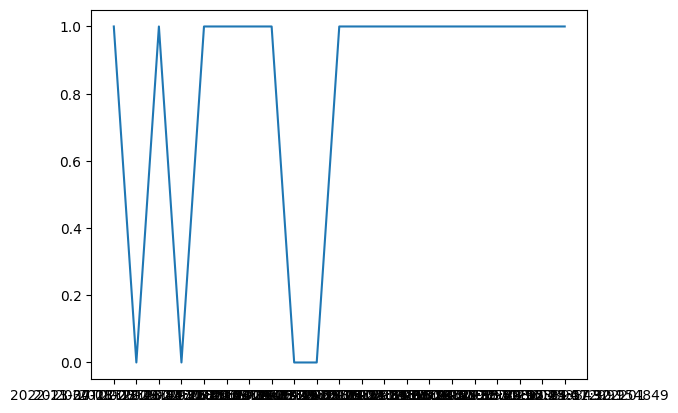

In [11]:
x = [r['date_added'] for r in recs]
y = [int(r['is_valid']) for r in recs]
display_markdown('### IsValid vs DateAdded', raw=True)
plt.plot(x, y) 
plt.show()

<a class="anchor" id="raw_analysis"></a>
## Raw Content Analysis

### Example of one record

In [12]:
rec = recs[-1]

msg = rec["message_text"]
md = f'Message text from log:\n> {msg}'
display_markdown(md, raw=True)

md = f'One full record (the last one retrieved):\n> {rec}'
display_markdown(md, raw=True)

display(rec)

Message text from log:
> investigating banding issue

One full record (the last one retrieved):
> {'id': 'f9a4b932-18e9-47db-9b7d-a2fbe3c15e70', 'site_id': 'tucson', 'obs_id': 'AT_O_20221115_000019', 'instrument': 'LATISS', 'day_obs': 20221115, 'seq_num': 19, 'message_text': 'investigating banding issue', 'level': 10, 'tags': ['background_issue'], 'urls': [], 'user_id': 'admin@love1.tu.lsst.org', 'user_agent': 'LOVE', 'is_human': True, 'is_valid': True, 'exposure_flag': 'questionable', 'date_added': '2022-11-16T04:57:30.954849', 'date_invalidated': None, 'parent_id': None}

{'id': 'f9a4b932-18e9-47db-9b7d-a2fbe3c15e70',
 'site_id': 'tucson',
 'obs_id': 'AT_O_20221115_000019',
 'instrument': 'LATISS',
 'day_obs': 20221115,
 'seq_num': 19,
 'message_text': 'investigating banding issue',
 'level': 10,
 'tags': ['background_issue'],
 'urls': [],
 'user_id': 'admin@love1.tu.lsst.org',
 'user_agent': 'LOVE',
 'is_human': True,
 'is_valid': True,
 'exposure_flag': 'questionable',
 'date_added': '2022-11-16T04:57:30.954849',
 'date_invalidated': None,
 'parent_id': None}

<a class="anchor" id="elicitation"></a>
## Stakeholder Elicitation

In [20]:
#EXTERNAL_INSTANCE_URL
ed = dict(os.environ.items())
with pd.option_context('display.max_rows', None,):
    print(pd.DataFrame(ed.values(), index=ed.keys()))

                                                                               0
SHELL                                                                  /bin/bash
SESSION_MANAGER                local/chimp20:@/tmp/.ICE-unix/6143,unix/chimp2...
QT_ACCESSIBILITY                                                               1
XDG_CONFIG_DIRS                                       /etc/xdg/xdg-mate:/etc/xdg
XDG_SESSION_PATH                        /org/freedesktop/DisplayManager/Session0
GTK_IM_MODULE                                                               ibus
LANGUAGE                                                                   en_US
TERMCAP                                                                         
SSH_AUTH_SOCK                                         /run/user/1000/keyring/ssh
INSIDE_EMACS                                                         29.4,comint
XMODIFIERS                                                              @im=ibus
DESKTOP_SESSION             